In [1]:
from smartem.segmentation import segmenter, utils
from skimage import measure, segmentation
from smartem.offline.train_mb_error_detector.NNtools import UNet

import h5py
import matplotlib.pyplot as plt
import torch, torchvision
import numpy as np
import pyvoi
import pandas as pd
import seaborn as sns
import segmentation_models_pytorch as smp
from skimage import io
from tqdm import tqdm
import time
from PIL import Image

/tmp/ipykernel_3001860/679427614.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/tommy-local/projects/smartem/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set variables

In [2]:
data_path = "/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5"
device = torch.device("cuda")

In [3]:
model = UNet.UNet(1,2)
model_path = '../../pretrained_models/em2mb_best.pth'

In [4]:
model = smp.Unet(
    encoder_name='resnet50', 
    encoder_weights='imagenet', 
    classes=2, 
    activation='sigmoid',
)

model_path = '/home/tommy-local/projects/smartem/smartem_support/fusedem2mb/best_model_EM2MB_noslow_state.pth'

## Make Segmenter object

In [4]:
Iseg = segmenter.Segmenter(model_path, segmenter_function = measure.label, device=device)
Iseg.set_model(model_class=model)

## Compute VI vs. Dwell Time

In [5]:
data_dwts = []
data_hdt_vois = []
data_gt_vois = []

with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys(), desc="segmenting regions..."):
        group = f[reg]

        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        mask = group[f"{slowest_dwt}/mask"][()]
        gt_labels = measure.label(255 - mask)

        if gt_labels.shape[0] % 32 != 0:
            gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

        # 1200ns
        im = group[f"{slowest_dwt}/im"][()]
        hdt_labels = Iseg.get_labels(im)


        # all dwts
        for dwt in tqdm(group.keys(), desc="segmenting dwell times...", leave=False):
            im = group[f"{dwt}/im"][()]

            labels = Iseg.get_labels(im)

            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels.flatten(), labels.flatten())
            data_gt_vois.append(voi_gt.item())
            data_hdt_vois.append(voi_hdt.item())
            data_dwts.append(int(dwt))



data = {"Dwell Time (ns)": data_dwts, "Variation of Information from GT": data_gt_vois, "Variation of Information from 1200ns": data_hdt_vois}
df = pd.DataFrame(data=data)

segmenting regions...: 100%|██████████| 18/18 [02:40<00:00,  8.92s/it]


<Axes: xlabel='Dwell Time (ns)', ylabel='Variation of Information from GT'>

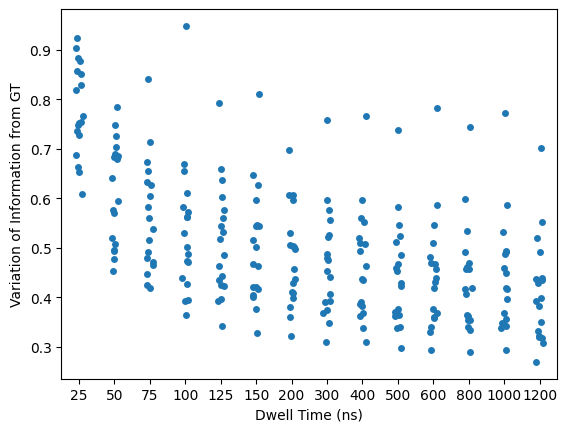

In [6]:
sns.stripplot(data=df, y="Variation of Information from GT", x="Dwell Time (ns)")

## Visualize result

In [14]:
images = {}

desired_dwts = [25, 50, 100, 400, 800, 1200]

with h5py.File(data_path, "r") as f:
    reg = list(f.keys())[0]
    group = f[reg]

    dwts = [int(dwt) for dwt in list(group.keys())]
    dwts.sort()
    slowest_dwt = dwts[-1]
    
    mask = group[f"{slowest_dwt}/mask"][()]

    gt_labels = measure.label(255 - mask)
    if gt_labels.shape[0] % 32 != 0:
        gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
    gt_labels_shuffled = utils.shuffle_labels(gt_labels)
    gt_labels_masked = np.ma.masked_where(gt_labels_shuffled == 0, gt_labels_shuffled)

    for dwt in desired_dwts:
        im = group[f"{dwt}/im"][()]

        _, mb_probs = Iseg.get_membranes(im, get_probs=True)
        labels = Iseg.get_labels(im)

        labels_shuffled = utils.shuffle_labels(labels)
        labels_masked = np.ma.masked_where(labels_shuffled == 0, labels_shuffled)

        voi,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
        title_stem = f"{dwt}ns_VOI_{voi.item():.2f}"

        images[title_stem + "_image"] = im
        images[title_stem + "_label"] = labels_masked
        images[title_stem + "_pred"] = mb_probs


images["ground_truth_image"] = im
images["ground_truth_label"] = gt_labels_masked
images["ground_truth_pred"] = mask
images["high_dwell_time_image"] = im


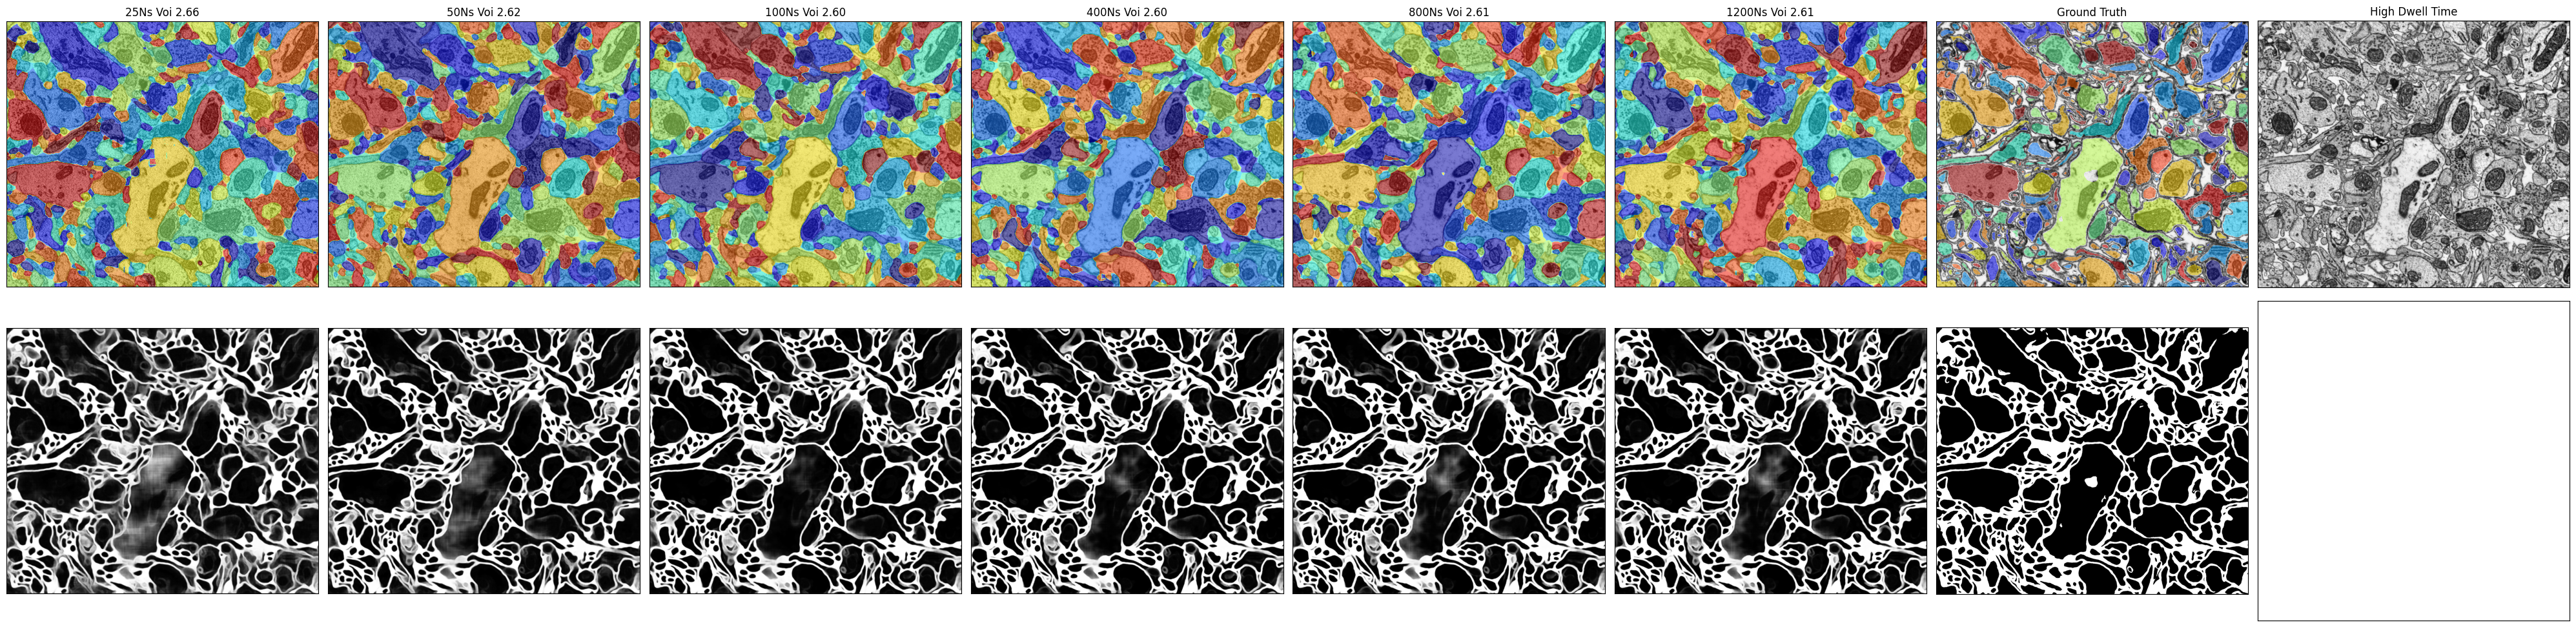

In [15]:
utils.visualize(**images)

## Save MB probs

In [37]:
out_path = "/storage2/projects/smartEM/em-vis/em2mb_preds/"
desired_dwts = [50, 1200]

with h5py.File(data_path, "r") as f:
    for reg in tqdm(list(f.keys()), desc="predicting images..."):
        group = f[reg]

        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        # all dwts
        for dwt in desired_dwts:

            im = group[f"{dwt}/im"][()]
            mask = group[f"{dwt}/mask"][()]

            im = np.pad(im, ((12,12), (0,0)))
            #print(f"{mask.shape}, {mask.dtype}, {np.amin(mask)}-{np.median(mask)}-{np.amax(mask)}")
            #print(f"{im.shape}, {im.dtype}, {np.amin(im)}-{np.median(im)}-{np.amax(im)}")

            _, mb_probs = Iseg.get_membranes(im, get_probs=True)

            mb_probs = mb_probs[12:-12,:]
            mb_probs = (mb_probs * 255).astype(np.uint8)
            #print(f"{mb_probs.shape}, {mb_probs.dtype}, {np.amin(mb_probs)}-{np.median(mb_probs)}-{np.amax(mb_probs)}")

            f_path = out_path + f"reg_{reg}_dwt_{dwt}_em2mb_pred.png"
            io.imsave(f_path, mb_probs)
            f_path_mask = out_path + f"reg_{reg}_dwt_{dwt}_gt.png"
            io.imsave(f_path_mask, mask)

            # plt.imshow(mb_probs, cmap='gray')
            # plt.show()
            # plt.imshow(mask, cmap='gray')
            # plt.show()
            
            #raise ValueError()




predicting images...: 100%|██████████| 8/8 [00:12<00:00,  1.50s/it]


## Compute VI vs. Step Size

In [24]:
data_av_hdt_vois = []
data_step_size = []

data_time_step = []
data_time_time = []

dwt = 50
step_sizes = [128, 256, 512, 1024]

with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys(), desc="segmenting regions..."):
        group = f[reg]

        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        mask = group[f"{slowest_dwt}/mask"][()]
        gt_labels = measure.label(255 - mask)

        if gt_labels.shape[0] % 32 != 0:
            gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

        # 1200ns
        im = group[f"{slowest_dwt}/im"][()]
        im = im[:1024, :]
        hdt_mbs = Iseg.get_membranes(im)
        #hdt_labels = Iseg.get_labels(im)


        im = group[f"{dwt}/im"][()]
        im = im[:1024, :]
        print(im.shape)
        for step_size in tqdm(step_sizes, desc="Changing step size...", leave=False):
            vois = []
            mbs = np.zeros_like(hdt_mbs)
            for step in range(0, im.shape[0], step_size):
                im_step = im[step:step+step_size]
                #hdt_labels_step = hdt_labels[step:step+step_size]
                tic = time.time()
                mb_step = Iseg.get_membranes(im_step)
                toc = time.time()
                data_time_time.append(toc-tic)
                data_time_step.append(im_step.size)
                #labels_step = Iseg.get_labels(im_step)
                mbs[step:step+step_size] = mb_step
                # voi_hdt,_,_ = pyvoi.VI(hdt_labels_step.flatten(), labels_step.flatten())
                # voi_hdt = voi_hdt.item()
                # vois.append(voi_hdt)
            
            iou = np.sum(np.logical_and(mbs, hdt_mbs)) / np.sum(np.logical_or(mbs, hdt_mbs))

            data_step_size.append(step_size)
            data_av_hdt_vois.append(iou)


data_time = {"Step Size (pixels)": data_time_step, "CNN Prediction Time (s)": data_time_time}
df_time = pd.DataFrame(data=data_time)
data = {"Step Size (pixels)": data_step_size, "Membrane IoU Slow Dwell Time Segmentation": data_av_hdt_vois}
df = pd.DataFrame(data=data)

segmenting regions...:   0%|          | 0/18 [00:00<?, ?it/s]

(1024, 1920)


segmenting regions...:   6%|▌         | 1/18 [00:01<00:24,  1.44s/it]

(1024, 1920)


segmenting regions...:  11%|█         | 2/18 [00:02<00:22,  1.38s/it]

(1024, 1920)


segmenting regions...:  17%|█▋        | 3/18 [00:04<00:20,  1.36s/it]

(1024, 1920)


segmenting regions...:  22%|██▏       | 4/18 [00:05<00:18,  1.36s/it]

(1024, 1920)


segmenting regions...:  28%|██▊       | 5/18 [00:06<00:17,  1.35s/it]

(1024, 1920)


segmenting regions...:  33%|███▎      | 6/18 [00:08<00:16,  1.35s/it]

(1024, 1920)


segmenting regions...:  39%|███▉      | 7/18 [00:09<00:14,  1.35s/it]

(1024, 1920)


segmenting regions...:  44%|████▍     | 8/18 [00:10<00:13,  1.35s/it]

(1024, 1920)


segmenting regions...:  50%|█████     | 9/18 [00:12<00:12,  1.35s/it]

(1024, 1920)


segmenting regions...:  56%|█████▌    | 10/18 [00:13<00:10,  1.35s/it]

(1024, 1920)


segmenting regions...:  61%|██████    | 11/18 [00:14<00:09,  1.36s/it]

(1024, 1920)


segmenting regions...:  67%|██████▋   | 12/18 [00:16<00:08,  1.36s/it]

(1024, 1920)


segmenting regions...:  72%|███████▏  | 13/18 [00:17<00:06,  1.36s/it]

(1024, 1920)


segmenting regions...:  78%|███████▊  | 14/18 [00:19<00:05,  1.37s/it]

(1024, 1920)


segmenting regions...:  83%|████████▎ | 15/18 [00:20<00:04,  1.36s/it]

(1024, 1920)


segmenting regions...:  89%|████████▉ | 16/18 [00:21<00:02,  1.36s/it]

(1024, 1920)


segmenting regions...:  94%|█████████▍| 17/18 [00:23<00:01,  1.36s/it]

(1024, 1920)


segmenting regions...: 100%|██████████| 18/18 [00:24<00:00,  1.36s/it]


Text(0.5, 1.0, 'Effect of Image Stepping on EM2MB Segmentation')

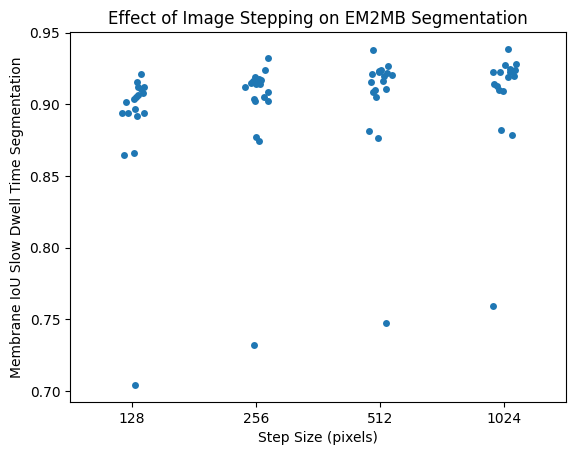

In [17]:
sns.stripplot(data=df, y="Membrane IoU Slow Dwell Time Segmentation", x="Step Size (pixels)")
plt.title("Effect of Image Stepping on EM2MB Segmentation")

<Axes: xlabel='Step Size (pixels)', ylabel='CNN Prediction Time (s)'>

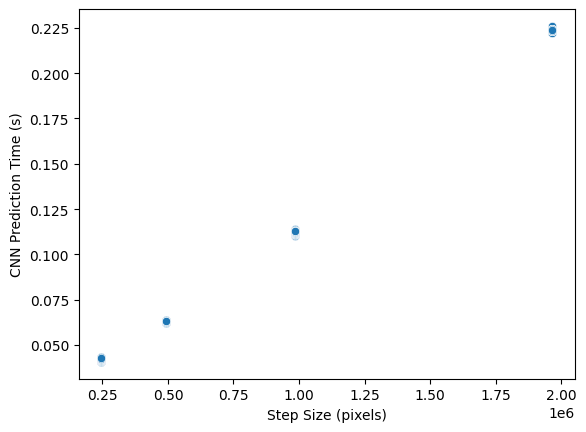

In [26]:
# f, ax = plt.subplots()
# ax.set(xscale="log")
sns.scatterplot(data=df_time, x="Step Size (pixels)", y="CNN Prediction Time (s)")

# Timing

In [3]:
em2mb_model = UNet.UNet(1,2)
em2mb_model = em2mb_model.to(device)
model_path = '/home/tommy-local/projects/smartem/SmartEM/pretrained_models/em2mb_best.pth'
weights = torch.load(model_path, map_location=device)
em2mb_model.load_state_dict(weights)
em2mb_model.eval()

errnet_model = UNet.UNet(1,2)
errnet_model = errnet_model.to(device)
model_path = '/home/tommy-local/projects/smartem/SmartEM/pretrained_models/error_best.pth'
weights = torch.load(model_path, map_location=device)
errnet_model.load_state_dict(weights)
errnet_model.eval()
print()

In [44]:
data_hdt_vois = []
data_step_size = []
data_av_hdt_ious = []

dwt = 50
step_sizes = [128, 256, 512, 1024]

with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys(), desc="segmenting regions..."):
        group = f[reg]

        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        mask = group[f"{slowest_dwt}/mask"][()]
        gt_labels = measure.label(255 - mask)

        if gt_labels.shape[0] % 32 != 0:
            gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

        # 1200ns
        im = group[f"{slowest_dwt}/im"][()]
        
        hdt_labels = Iseg.get_labels(im)
        hdt_membranes = Iseg.get_membranes(im)

        im = group[f"{dwt}/im"][()]
        im = im[:1024, :]
        for step_size in tqdm(step_sizes, desc="Changing step size...", leave=False):
            vois = []
            ious = []
            membranes = np.zeros_like(im)
            for step in range(0, im.shape[0], step_size):
                im_step = im[step:step+step_size]
                membranes_step = Iseg.get_membranes(im_step)
                membranes[step:step+step_size] = membranes_step

                iou_step = get_IoU(membranes_step, hdt_membranes[step:step+step_size])
                ious.append(iou_step)
            
            labels = Iseg.get_labels_from_membrane(membranes)
            
            # print(labels.shape, hdt_labels.shape)
            voi_hdt,_,_ = pyvoi.VI(hdt_labels[:1024,:].flatten(), labels.flatten())
            voi_hdt = voi_hdt.item()
            data_step_size.append(step_size)
            data_av_hdt_ious.append(np.mean(ious))
            # data_av_hdt_vois.append(np.mean(vois))
            data_hdt_vois.append(voi_hdt)



segmenting regions...: 100%|██████████| 18/18 [01:27<00:00,  4.85s/it]


In [24]:
# data = {"Step Size (pixels)": data_step_size, "Variation of Information from Slow Dwell Time Segmentation": data_hdt_vois}
data = {"Step Size (pixels)": data_step_size, "Av. IoU from Slow Dwell Time MB": data_av_hdt_ious, "Variation of Information from Slow Dwell Time Segmentation": data_hdt_vois}
df = pd.DataFrame(data=data)

Text(0.5, 1.0, 'Effect of Image Stepping on EM2MB Segmentation')

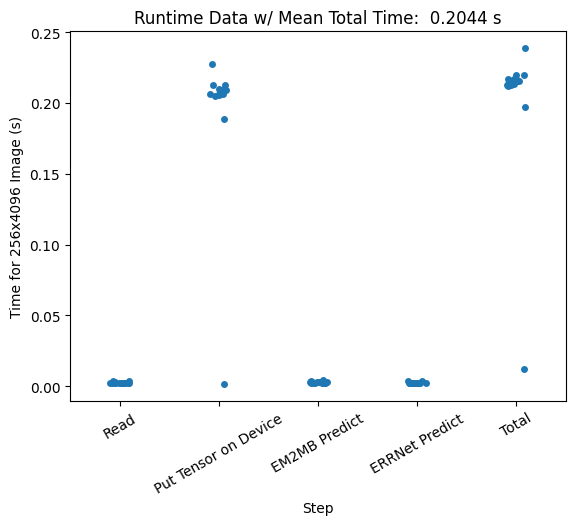

In [15]:
height = 256
data_times = []
data_type = []
total_times = []

with h5py.File(data_path, "r") as f:
    with torch.no_grad():
        for reg in tqdm(f.keys(), desc="segmenting regions..."):
            image = f[reg]['50']['im'][()]
            num_elem = image.size // 4096
            sub_im = image.flatten()[:num_elem*4096]
            sub_im = np.reshape(sub_im, [-1, 4096])
            sub_im = sub_im[:height, :].astype('float') / 255

            io.imsave("./im_strip.tif", sub_im)
            pil_im = Image.fromarray(sub_im)
            pil_im = pil_im.convert("L")
            pil_im.save("im_strip.png","PNG")

            tic = time.time()
            #sub_im = io.imread("./im_strip.tif")
            sub_im = torchvision.io.read_image("./im_strip.png").float()
            sub_im = sub_im.unsqueeze(0)
            toc_read = time.time()

            sub_im = sub_im.to(device=device)
            toc_totensor = time.time()

            mb_prob = em2mb_model(sub_im)[:,1:,:,:]
            toc_mb_pred = time.time()

            err = errnet_model(mb_prob)
            err = err > 0.5
            del sub_im, mb_prob, err
            toc_err_pred = time.time()

            data_type.append("Read")
            data_times.append(toc_read-tic)

            data_type.append("Put Tensor on Device")
            data_times.append(toc_totensor - toc_read)

            data_type.append("EM2MB Predict")
            data_times.append(toc_mb_pred - toc_totensor)

            data_type.append("ERRNet Predict")
            data_times.append(toc_err_pred - toc_mb_pred)

            data_type.append("Total")
            data_times.append(toc_err_pred - tic)


time_label = f"Time for {height}x4096 Image (s)"
data = {time_label: data_times, "Step": data_type}
df = pd.DataFrame(data=data)

sns.stripplot(df, y=time_label, x="Step")

plt.title(f"Runtime Data w/ Mean Total Time: {df[df['Step'] == 'Total'][time_label].mean(): .4f} s")
plt.xticks(rotation=30)

Text(0.5, 1.0, 'Effect of Image Stepping on EM2MB Segmentation')

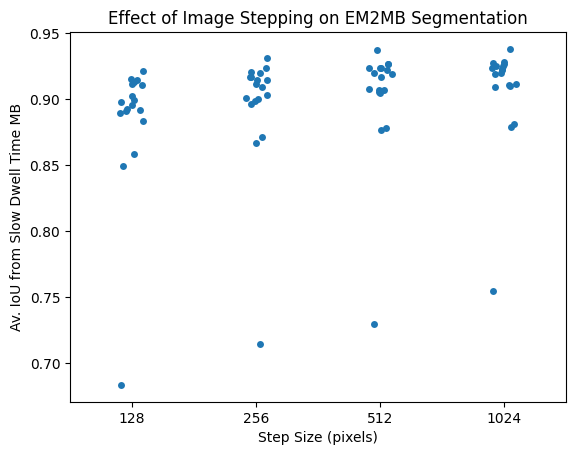

In [25]:
sns.stripplot(data=df, y="Av. IoU from Slow Dwell Time MB", x="Step Size (pixels)")
plt.title("Effect of Image Stepping on EM2MB Segmentation")

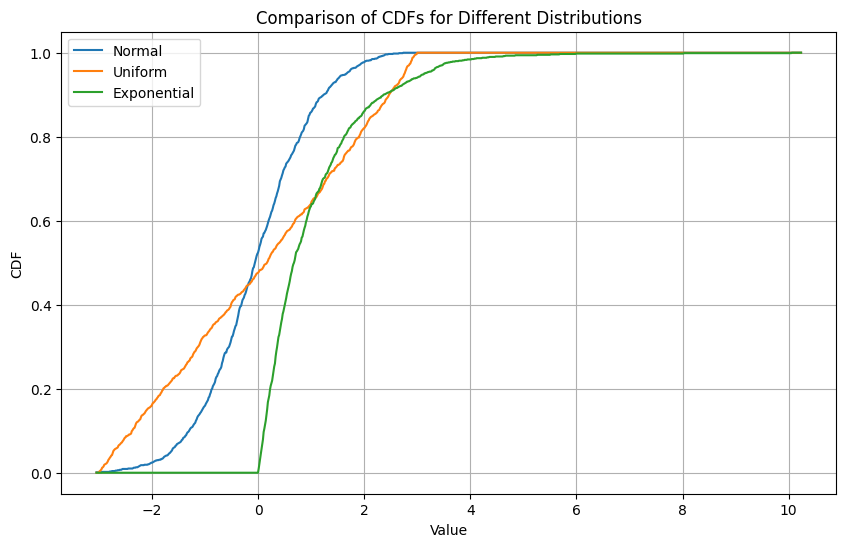

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Generate sample data
np.random.seed(0)
data_normal = np.random.normal(loc=0, scale=1, size=1000)
data_uniform = np.random.uniform(low=-3, high=3, size=1000)
data_exponential = np.random.exponential(scale=1, size=1000)

# Function to calculate CDF
def compute_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    return sorted_data, cdf

# Compute CDFs
x_normal, y_normal = compute_cdf(data_normal)
x_uniform, y_uniform = compute_cdf(data_uniform)
x_exponential, y_exponential = compute_cdf(data_exponential)

# Interpolate CDFs over a common x-range
x_common = np.linspace(min(min(x_normal), min(x_uniform), min(x_exponential)), 
                       max(max(x_normal), max(x_uniform), max(x_exponential)), 1000)

f_normal = interp1d(x_normal, y_normal, kind='nearest', bounds_error=False, fill_value=(0,1))
f_uniform = interp1d(x_uniform, y_uniform, kind='nearest', bounds_error=False, fill_value=(0,1))
f_exponential = interp1d(x_exponential, y_exponential, kind='nearest', bounds_error=False, fill_value=(0,1))

y_normal_interp = f_normal(x_common)
y_uniform_interp = f_uniform(x_common)
y_exponential_interp = f_exponential(x_common)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_common, y_normal_interp, label='Normal')
plt.plot(x_common, y_uniform_interp, label='Uniform')
plt.plot(x_common, y_exponential_interp, label='Exponential')
plt.title('Comparison of CDFs for Different Distributions')
plt.xlabel('Value')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()


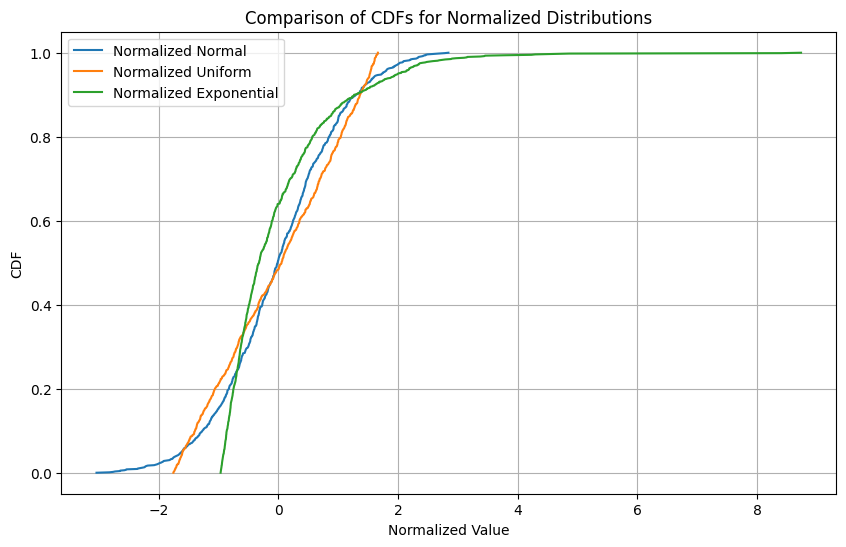

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
np.random.seed(0)
data_normal = np.random.normal(loc=0, scale=1, size=1000)
data_uniform = np.random.uniform(low=-3, high=3, size=1000)
data_exponential = np.random.exponential(scale=1, size=1000)

# Normalize data to zero mean and unit variance
normalize = lambda data: (data - np.mean(data)) / np.std(data)
data_normal_normalized = normalize(data_normal)
data_uniform_normalized = normalize(data_uniform)
data_exponential_normalized = normalize(data_exponential)

# Function to calculate CDF
def compute_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    return sorted_data, cdf

# Compute CDFs
x_normal, y_normal = compute_cdf(data_normal_normalized)
x_uniform, y_uniform = compute_cdf(data_uniform_normalized)
x_exponential, y_exponential = compute_cdf(data_exponential_normalized)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_normal, y_normal, label='Normalized Normal')
plt.plot(x_uniform, y_uniform, label='Normalized Uniform')
plt.plot(x_exponential, y_exponential, label='Normalized Exponential')
plt.title('Comparison of CDFs for Normalized Distributions')
plt.xlabel('Normalized Value')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()

